In [1]:
%matplotlib inline

## Imports

In [2]:
import re
import string
import os
from itertools import product

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

import pandas as pd
import seaborn as sns
# sns.set_context('talk')

In [3]:
def unescape_trackname(name):
    """Returns a string where all the hexadicimal sub-strings are decoded.

    gmtk converts non-alphanumerical character to hexadecimal and prepend
    an underscore. For example the the following track name "abc+"
    is converted to "abc_2B".

    This function finds the occurences of "_XX" and replaces it with its decoded version.

    >>> some_name = 'endswithaplus_2B'
    >>> unescape_trackname(some_name)
    endswithaplus+
    """

    gmtk_hexa_pattern = re.compile('_[0-9a-fA-F]{2}')

    for found_pattern in gmtk_hexa_pattern.findall(name):
        hexa_string = found_pattern.replace('_', '')
        hexa_string_decoded = hexa_string.decode('hex')

        name = name.replace(found_pattern, hexa_string_decoded)

    return name

In [4]:
def gmtk_means_to_df(filename):
    # Load all the lines in a list
    with open(filename, 'r') as file_handler:
        param_lines = [line.strip() for line in file_handler]

    # Here I assume that lines of interest start with the following pattern
    mean_seg_line_re = re.compile('mean_seg(\d+)_subseg\d+_(\w+)_component\d+ \d (.*)')
    mean_seg_lines = filter(mean_seg_line_re.match, param_lines)

    # Extract label, mean and track name information and store it in a list of tuple
    label_track_mean_tuples = [mean_seg_line_re.match(line).groups() for line in mean_seg_lines]

    gmtk_df = pd.DataFrame(label_track_mean_tuples, columns=['label', 'track', 'gmtk_mean'])

    # decode hexadecimal string
    gmtk_df.track = gmtk_df.track.map(unescape_trackname)

    # convert dataframe to a matrix
    gmtk_matrix = gmtk_df.pivot(values='gmtk_mean', index='track', columns='label').astype(float)

    return gmtk_matrix

In [5]:
def annotate_heatmap(annotation_df, ax, text_kws={}):
    """ (DataFrame, Axis) -> None
    
    pre-condition: annotation_df.shape == ax.shape
    
    Write annotations from annotation_df in the heatmap within ax.
    """
    text_props = dict(color='black', fontsize=12, ha='center', va='center')
    text_props.update(text_kws)
    
    # reverse indexes to matches the heatmap axes
    reversed_df = annotation_df.iloc[::-1]
    row_indexes, col_indexes = map(range, reversed_df.shape)
    
    for row_index, col_index in product(row_indexes, col_indexes):

        text = reversed_df.iloc[row_index, col_index]
        
        ax.annotate(text, (col_index + 0.5, row_index + 0.5), **text_props)

In [6]:
GMTK_OUTPUT_DIR = 'gmtk_params'

if not os.path.exists(GMTK_OUTPUT_DIR):
    os.mkdir(GMTK_OUTPUT_DIR)

## Define annotation heatmap (Edit)

The following DataFrame (DF) is use to draw an annotation heatmap next to the gmtk parameter heatmap. The DF should contain 3 columns:
- name: the full name of the annotation displayed in the legend
- shortname: a short version of the full name that should fit in a heatmap bin
- color: the color used in the annotation heatmap


In [7]:
# load 18 colors from Pastel1 and Pastel2
# colors are used in the annotation heatmap
pastel1 = sns.color_palette('Pastel1', 9).as_hex()
pastel2 = sns.color_palette('Pastel2', 9).as_hex()

custom_pal = pastel1 + pastel2

annotation_info = pd.DataFrame([
    {'name': 'Annotation1', 'shortname':'A1', 'color': custom_pal[0]}, #8
    {'name': 'Annotation2', 'shortname':'A2', 'color': custom_pal[2]},
    {'name': 'Annotation3', 'shortname':'A3', 'color': custom_pal[3]},
    {'name': 'Annotation4', 'shortname':'A4', 'color': custom_pal[4]},
    {'name': 'Annotation5', 'shortname':'A5', 'color': custom_pal[5]},
    {'name': 'Annotation6', 'shortname':'A6', 'color': custom_pal[6]},
    {'name': 'Annotation7', 'shortname':'A7', 'color': custom_pal[7]},
    {'name': 'Annotation8', 'shortname':'A8', 'color': custom_pal[8]},
    {'name': 'Annotation9', 'shortname':'A9', 'color': custom_pal[9]},
    
])

annotation_info['id'] = annotation_info.index

In [8]:
name_to_shortname = {row.name: row.shortname for row in annotation_info.itertuples()}
name_to_id = {row.name: row.id for row in annotation_info.itertuples()}
shortname_to_row = {row.shortname: row for row in annotation_info.itertuples()}

## Parse gmtk params file (Edit)

In [9]:
GMTK_PARAM_FILENAME = 'params 1.params'
gmtk_param_df = gmtk_means_to_df(GMTK_PARAM_FILENAME).T

In [10]:
gmtk_param_df

track,ENCSR000CIL_+,ENCSR000CIM_+,ENCSR000COK_+,ENCSR000CPS_+
label,,,,
0,0.002440,0.005679,0.615884,0.930908
1,0.013082,0.013558,2.049281,1.414483
2,0.778701,0.665901,1.233042,0.677967
3,0.022213,0.024792,3.249750,2.503745


## Load annotation metadata (Edit)

The annoation metadata are the metadata associated with each Segway tracks. 
- The first level keys should be the same as the columns of the `gmtk_param_df` defined above
- The values of the second level dicts (Annotation1, ...) should all be defined in the `annotion_info` DF defined above

In [11]:
metadata_dicts = {
    'ENCSR000CIL_+': {'Col1': 'Annotation1', 'Col2': 'Annotation2'},
    'ENCSR000CIM_+': {'Col1': 'Annotation3', 'Col2': 'Annotation4'},
    'ENCSR000COK_+': {'Col1': 'Annotation5', 'Col2': 'Annotation6'},
    'ENCSR000CPS_+': {'Col1': 'Annotation7', 'Col2': 'Annotation8'},
}
annotation_df = pd.DataFrame(metadata_dicts).T

In [12]:
annotation_df

,Col1,Col2
ENCSR000CIL_+,Annotation1,Annotation2
ENCSR000CIM_+,Annotation3,Annotation4
ENCSR000COK_+,Annotation5,Annotation6
ENCSR000CPS_+,Annotation7,Annotation8


In [13]:
colors = annotation_info.sort_values(by='id').color.tolist()
annotation_cmap = mpl.colors.ListedColormap(colors)
heatmap_cmap = sns.diverging_palette(220, 10, as_cmap=True)

heatmap_df = annotation_df.replace(name_to_id)
shortname_df = annotation_df.replace(name_to_shortname)

## Prepare legends

In [14]:
patches = {}

for col in shortname_df.columns:
    p_list = []
    for ann in shortname_df[col].unique():
        tup = shortname_to_row[ann]
        p = mpatches.Patch(color=tup.color, label='{}: {}'.format(tup.shortname, tup.name), linestyle='solid')
        p_list.append(p)
    
    patches[col] = p_list

## Perform hierarchical clustering

In [15]:
track_dist = pdist(gmtk_param_df.T)
track_linkage = sch.linkage(track_dist)
track_leaves = sch.dendrogram(track_linkage, no_plot=True)['leaves']

In [16]:
label_dist = pdist(gmtk_param_df)
label_linkage = sch.linkage(label_dist)
label_leaves = sch.dendrogram(label_linkage, no_plot=True)['leaves']

In [17]:
n_label = gmtk_param_df.index.size

In [18]:
gmtk_final_df = gmtk_param_df.iloc[label_leaves, track_leaves].T

## Raw parameters

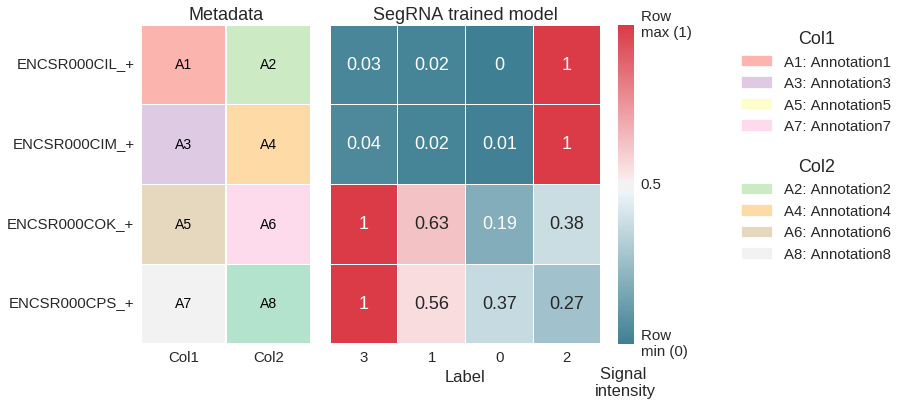

In [19]:
FONT_SCALE = 1.5
FIGSIZE = (10,6)

# width ratio of the two heatmaps
WIDTH_RATIO = [1, 2]

# number of decimals to round the mean gmtk params
ROUND_MEANS = 2

# show means in the gmtk heatmap
ANNOT = True

# Columns for which to plot a lengend
COLS = annotation_df.columns

ROW_NORMALIZE = True

if ROW_NORMALIZE:
    param_df = gmtk_final_df.div(gmtk_final_df.max(1), axis=0)
else:
    param_df = gmtk_final_df

sns.set(font_scale=FONT_SCALE)

# Start plotting
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, 
                         gridspec_kw={'width_ratios':WIDTH_RATIO}, sharey=True)

fig.subplots_adjust(wspace=0.05)

# Plot parameters heatmap
params_ax = sns.heatmap(param_df.round(ROUND_MEANS), cmap=heatmap_cmap, ax=axes[1], 
                        linewidths=0.1, annot=ANNOT)

# Plot the side annotation heatmap
sns.heatmap(heatmap_df.loc[gmtk_final_df.index], cmap=annotation_cmap, cbar=None, ax=axes[0], 
            linewidths=0.1)

# Populate the annotation heatmap with annotation shortnames
annotate_heatmap(shortname_df.loc[gmtk_final_df.index], axes[0], {'fontsize': 14})

# Plot legends
for i, col in enumerate(COLS[:-1]):
    legend = plt.legend(handles=patches[col], bbox_to_anchor=(1.5, 1 - i*0.2), 
                        loc=2, borderaxespad=0., title=col)
    ax = plt.gca().add_artist(legend)

legend = plt.legend(handles=patches[COLS[-1]], bbox_to_anchor=(1.5, 1 - len(COLS)*0.2),
                    loc=2, borderaxespad=0., title=COLS[-1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('Label')
axes[0].set_title('Metadata')
axes[1].set_title('SegRNA trained model')

cbar = params_ax.collections[0].colorbar
cbar.ax.set_xlabel('\nSignal \nintensity')

if ROW_NORMALIZE:
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['Row \nmin (0)', '0.5', 'Row \nmax (1)'])

plt.tight_layout()

fig.savefig('{}/gmtk_params.png'.format(GMTK_OUTPUT_DIR), bbox_inches='tight')
fig.savefig('{}/gmtk_params.svg'.format(GMTK_OUTPUT_DIR), bbox_inches='tight')